Working with WherobotsDB like the Spatial DataFrame structure and querying WherobotsDB databases and tables using Spatial SQL.

1. Read Vector and Raster Data
2. Visualizing Data
3. Scaled Spatial Joins between vector and multiple raster layers

Data sets:

Burn Probability
Overture Maps
Buildings
Places (Fire Stations)

Process:

Define mapping units
Zonal Stats on Burn Probability
Calculate Building Densities
KNN to fire stations
Combine Metrics
Hot-Spot Detection
Profit

Creation the `Context` which represents the connection to the cluster. Set the config and create the `Context` all of the nodes in the cluster are brought on line

In [1]:
%%time
from sedona.spark import *
from pyspark.sql.functions import col, count, when, expr,lit,explode,broadcast, desc
from datetime import datetime
start = datetime.now()

config = SedonaContext.builder(). \
    config("spark.hadoop.fs.s3a.bucket.wherobots-examples.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()


sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


CPU times: user 449 ms, sys: 81.7 ms, total: 531 ms
Wall time: 24.8 s


First layer to perpare is a "Burn Probability" Layer generaeted for by the USDA and Forest Service.
This raster represents "the annual probability of wildfire burning in a specific location."

In [2]:
%%time
analysis_start = datetime.now()
burn_probability = "s3://wherobots-examples/data/examples/SDSC/BP-clip-reblock-4326.tif"
exclusion_wkt = "MultiPolygon (((-119.22425369 31.67241078, -119.03742835 30.92881246, -117.00686077 31.26615639, -117.24927621 32.01643187, -117.36169794 32.50929768, -117.40697765 32.65986814, -117.45368807 32.79856211, -117.50463868 32.9832308, -117.59444643 33.13521645, -117.81002531 33.3313064, -118.16274878 33.51473174, -118.44751165 33.54860864, -118.54278981 33.70994242, -118.62402192 33.86683156, -118.77557516 33.93388227, -118.86933137 33.98250615, -118.89850234 33.97769324, -119.25883116 33.91883788, -119.84475305 33.82227912, -119.35342742 32.16682393, -119.28359676 31.88814932, -119.22425369 31.67241078)))"

burn_probability_df = sedona.sql(f"""
SELECT 
    'BP-clip-4326.tif' AS path, 
    RS_FromPath("{burn_probability}") AS rast""")
burn_probability_df.createOrReplaceTempView("burn_probability")

CPU times: user 2.32 ms, sys: 316 μs, total: 2.63 ms
Wall time: 72.4 ms


In [4]:
burn_probability_df.show()

+----------------+--------------------+
|            path|                rast|
+----------------+--------------------+
|BP-clip-4326.tif|LazyLoadOutDbGrid...|
+----------------+--------------------+



RS_TileExplode – raster splitting:
Explodes rasters from the burn_probability table into smaller tiles of size 256x256 pixels.
Returns the x, y coordinates, the tile, and the path to the original file (path).

For each tile, the following are calculated:

maximum (max_bp),

average (mean_bp),

minimum (min_bp) pixel values.

In [5]:
burn_probability_df_tiled = sedona.sql(f""" 
with exp_raster as (
SELECT 
    RS_TileExplode(rast,256,256) as (x, y, tile),
    path
from burn_probability ),

exp_ras_sub as(
select * from exp_raster
where  ST_INTERSECTS(RS_ENVELOPE(tile), ST_GEOMFROMWKT('{exclusion_wkt}')) = False)


SELECT
    *, 
    RS_SUMMARYSTATS(tile,'max') as max_bp,
    RS_SUMMARYSTATS(tile,'mean') as mean_bp, 
    RS_SUMMARYSTATS(tile,'min') as min_bp
from exp_ras_sub 
where  RS_SUMMARYSTATS(tile, 'count') > 0
"""
                                )
burn_probability_df_tiled.createOrReplaceTempView("burn_probability_tiled")

In [7]:
burn_probability_df_tiled.show()

+---+---+--------------------+----------------+--------------------+--------------------+--------------------+
|  x|  y|                tile|            path|              max_bp|             mean_bp|              min_bp|
+---+---+--------------------+----------------+--------------------+--------------------+--------------------+
| 36|  0|OutDbGridCoverage...|BP-clip-4326.tif|1.813595881685614...|1.674966199030506...|1.133820987888611...|
| 37|  0|OutDbGridCoverage...|BP-clip-4326.tif|1.796089054550975...| 2.02409643301056E-5|                 0.0|
| 38|  0|OutDbGridCoverage...|BP-clip-4326.tif|1.091641970560886E-4|4.415770374645719E-5|                 0.0|
| 39|  0|OutDbGridCoverage...|BP-clip-4326.tif| 2.70210177404806E-4|1.877037333675001...|6.132179987616837E-5|
| 40|  0|OutDbGridCoverage...|BP-clip-4326.tif| 3.84111306630075E-4|1.884996068701906...|1.596019319549668...|
| 41|  0|OutDbGridCoverage...|BP-clip-4326.tif|1.750174124026671E-4|5.081813900446140...|9.999999747378752E-6|
|

In [8]:
%%time
burn_probability_df_tiled.select("x", "y","mean_bp","max_bp","min_bp").show(truncate=False)

+---+---+---------------------+---------------------+---------------------+
|x  |y  |mean_bp              |max_bp               |min_bp               |
+---+---+---------------------+---------------------+---------------------+
|36 |0  |1.6749661990305068E-4|1.8135958816856146E-4|1.1338209878886119E-4|
|37 |0  |2.02409643301056E-5  |1.7960890545509756E-4|0.0                  |
|38 |0  |4.415770374645719E-5 |1.091641970560886E-4 |0.0                  |
|39 |0  |1.8770373336750017E-4|2.70210177404806E-4  |6.132179987616837E-5 |
|40 |0  |1.8849960687019061E-4|3.84111306630075E-4  |1.5960193195496686E-5|
|41 |0  |5.0818139004461404E-5|1.750174124026671E-4 |9.999999747378752E-6 |
|42 |0  |1.4710356230911117E-5|1.0809641389641911E-4|0.0                  |
|43 |0  |3.0346563184530973E-5|2.135593385901302E-4 |0.0                  |
|44 |0  |5.460342439923773E-5 |1.5832169447094202E-4|9.999999747378752E-6 |
|29 |1  |0.0015682515791720834|0.0018817137461155653|0.0010702286381274462|
|30 |1  |0.0

Generate  mapping unit, H3 Level 7 hexagons

In [9]:
%%time
h3_level=6



hex_df = sedona.sql(f""" 
WITH h3_ids AS (SELECT 
   DISTINCT EXPLODE
               (
                   ST_H3CellIDs(RS_Envelope(tile), {h3_level}, true)
               ) AS h3 
FROM 
burn_probability_tiled),

exp_h3 as (
SELECT 
    h3,
    EXPLODE (ST_H3ToGeom(ARRAY(h3))) AS geometry
FROM 
    h3_ids)

select * from exp_h3 
where  ST_INTERSECTS(geometry, ST_GEOMFROMWKT('{exclusion_wkt}')) = False
""").repartition(15).cache()

hex_df.createOrReplaceTempView("mapping_units")
hex_df.count()

CPU times: user 16.9 ms, sys: 866 μs, total: 17.7 ms
Wall time: 1min


1456

In [11]:
tiledMap = SedonaKepler.create_map()
SedonaKepler.add_df(tiledMap, hex_df, name="h3")
SedonaKepler.add_df(tiledMap, burn_probability_df_tiled.withColumn("tile", expr("RS_Envelope(tile)")).withColumn("area",expr("ST_AREA(tile)")), name="tiles")
tiledMap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'h3': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, …

Calculate Building Density
Use Overture Maps Foundation Buildings data set to calculate building density metric for composit riskl score.

In [12]:
hex_df.printSchema()

root
 |-- h3: long (nullable = true)
 |-- geometry: geometry (nullable = true)



Creation one common geometry (AOI – Area of Interest) by unifying all hexagons from the mapping_units view.
ST_Union_Aggr(geometry) – Sedona's aggregate function:
Unites all geometries (hexagons) into one aggregate geometry (multi-polygon or polygon).
This is more efficient than the sequential ST_Union because it works as an aggregate.

.collect()[0].geom:
Runs the query (collect() takes the result as a list of rows).
Gets the first (and only) row with a column geom.
Assigns this result to the aoi_geom variable.

In [13]:
%%time

aoi_geom = sedona.sql("""select ST_Union_Aggr(geometry) as geom
    from mapping_units""").collect()[0].geom

CPU times: user 5.2 ms, sys: 148 μs, total: 5.35 ms
Wall time: 662 ms


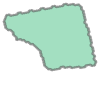

In [15]:
aoi_geom

In [16]:
%%time
aoi_buildings_df = sedona.sql(
f"""
select 
    ID, geometry
from 
    wherobots_open_data.overture_2024_05_16.buildings_building
where 
    ST_WITHIN(geometry,ST_GEOMFROMWKT('{aoi_geom}')) """)

CPU times: user 2.77 ms, sys: 0 ns, total: 2.77 ms
Wall time: 1.44 s


In [17]:
%%time
aoi_buildings_df = aoi_buildings_df.repartition(100)
aoi_buildings_df.createOrReplaceTempView('aoi_buildings')
aoi_buildings_df.count()

CPU times: user 17.9 ms, sys: 2.42 ms, total: 20.3 ms
Wall time: 13.3 s


8509401

In [18]:
%%time
building_density_df = sedona.sql(
"""
Select 
    t1.h3,
    t1.geometry,
    COUNT(t2.ID) building_count,
    (SUM(ST_AreaSpheroid(t2.geometry))/ST_AreaSpheroid(t1.geometry)) building_density
FROM 
    mapping_units t1
 JOIN
    aoi_buildings t2
ON
    ST_INTERSECTS(t1.geometry,ST_CENTROID(t2.geometry))
GROUP BY
    t1.h3,
    t1.geometry
""" 
)
building_density_df.createOrReplaceTempView("building_density")

CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 44.6 ms


In [19]:
%%time
building_density_df = building_density_df.cache()
building_density_df.show(20)

+------------------+--------------------+--------------+--------------------+
|                h3|            geometry|building_count|    building_density|
+------------------+--------------------+--------------+--------------------+
|604214645481275391|POLYGON ((-116.81...|          2366|0.008779348293244886|
|604214651923726335|POLYGON ((-117.25...|         13717| 0.10129795743245162|
|604214731917492223|POLYGON ((-118.64...|          3578|0.018010992210975345|
|604214660782096383|POLYGON ((-117.52...|           235|0.001084597139425559|
|604214631119978495|POLYGON ((-117.40...|          3463|0.022337953283936337|
|604214663063797759|POLYGON ((-117.47...|           279|0.001117218401442...|
|604214903716184063|POLYGON ((-117.31...|             9|6.078803896774047E-5|
|604214633535897599|POLYGON ((-117.55...|            11|3.820247750130015...|
|604214811105951743|POLYGON ((-116.75...|            12|5.605720815404745E-5|
|604215093097398271|POLYGON ((-115.67...|             2|2.311848

In [20]:
%%time
max_burn_df = sedona.sql(f"""

SELECT
    t1.h3,
    t1.geometry,
    t1.building_count,
    t1.building_density,
    MAX(t2.max_bp) as max_bp, 
    MIN(t2.min_bp) as min_bp,
    AVG(t2.mean_bp) as mean_bp,
    MAX(t2.max_bp) - MIN(t2.min_bp) as range_bp

from 
    building_density t1
 join
  burn_probability_tiled t2
on ST_INTERSECTS(t1.geometry,RS_ENVELOPE(t2.tile))
group by 
1,2,3,4


""")
max_burn_df = max_burn_df.cache()
max_burn_df.createOrReplaceTempView("max_burn")
max_burn_df.show()

+------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                h3|            geometry|building_count|    building_density|              max_bp|              min_bp|             mean_bp|            range_bp|
+------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|604214645481275391|POLYGON ((-116.81...|          2366|0.008779348293244886| 0.04732268303632736|                 0.0|0.009512943033608173| 0.04732268303632736|
|604214651923726335|POLYGON ((-117.25...|         13717| 0.10129795743245162|0.002469598548486829|                 0.0|5.739324459825393E-4|0.002469598548486829|
|604214731917492223|POLYGON ((-118.64...|          3578|0.018010992210975345|0.025503288954496384|                 0.0|0.003979053346991...|0.025503288954496384|
|604214660782096383|POLYGON 

In [21]:
building_density_df.unpersist()

DataFrame[h3: bigint, geometry: udt, building_count: bigint, building_density: double]

In [22]:
max_burn_df.printSchema()

root
 |-- h3: long (nullable = true)
 |-- geometry: geometry (nullable = true)
 |-- building_count: long (nullable = false)
 |-- building_density: double (nullable = true)
 |-- max_bp: double (nullable = true)
 |-- min_bp: double (nullable = true)
 |-- mean_bp: double (nullable = true)
 |-- range_bp: double (nullable = true)



Prepare for a KNN join. Extract all the fire stations by primary catagory and using our AOI for spatial filter pushdown.

In [23]:
%%time
fire_stateion_df = sedona.sql(f"""
select * from 
    wherobots_open_data.overture_2024_07_22.places_place  
WHERE 
    categories.primary in ('fire_department')
AND
    ST_WITHIN(geometry,ST_GEOMFROMWKT('{aoi_geom}'))
""")
fire_stateion_df.count()
fire_stateion_df.createOrReplaceTempView("fire_stations")

CPU times: user 5.53 ms, sys: 198 μs, total: 5.73 ms
Wall time: 1.99 s


In [24]:
%%time
df_knn_join = sedona.sql("""
SELECT
    source.GEOMETRY AS SOURCE_GEOM,
    SOURCE.h3 AS h3,
    sink.GEOMETRY AS sink_GEOM,
    ST_DISTANCESPHERE(source.GEOMETRY, sink.GEOMETRY) AS DISTANCE,
    ST_MAKELINE(ST_CENTROID(source.GEOMETRY), sink.GEOMETRY) AS LINE
FROM max_burn source

JOIN fire_stations sink ON ST_AKNN(source.GEOMETRY, sink.GEOMETRY, 1, FALSE)
""")

CPU times: user 1.96 ms, sys: 377 μs, total: 2.34 ms
Wall time: 39.3 ms


In [25]:
%%time
df_unique_qid = df_knn_join.dropDuplicates(["SOURCE_GEOM"])

# Perform an inner join to get all rows from join_df that have QIDs in unique_qid_df
df_related_rows = df_knn_join.join(df_unique_qid, on="h3", how="inner").select(df_knn_join["*"])

df_unique_qid.cache()
df_related_rows.cache()
df_related_rows.createOrReplaceTempView("fire_station_distance")
df_related_rows.count()

25/05/02 16:14:17 WARN JoinQueryDetector: Warning: One or more filter pushdowns have been detected on the object side of the KNN join. 
These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;


These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;
These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FR

25/05/02 16:14:18 WARN JoinQueryDetector: Warning: One or more filter pushdowns have been detected on the object side of the KNN join. 
These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;
25/05/02 16:14:18 WARN JoinQueryDetector: Warning: One or more filter pushdowns have been detected on the object side of the KNN join. 
These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you mater

These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;


25/05/02 16:14:21 WARN JoinQueryDetector: Warning: One or more filter pushdowns have been detected on the object side of the KNN join. 
These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;


These filters will be applied to the object side reader before the KNN join is executed. 
If you intend to apply the filters after the KNN join, please ensure that you materialize the KNN join results before applying the filters. 
For example, you can use the following approach:

Scala Example:
val knnResult = knnJoinDF.cache()
val filteredResult = knnResult.filter(condition)

SQL Example:
CREATE OR REPLACE TEMP VIEW knnResult AS
SELECT * FROM (
  -- Your KNN join SQL here
) AS knnView
CACHE TABLE knnResult;
SELECT * FROM knnResult WHERE condition;


CPU times: user 9.78 ms, sys: 8.29 ms, total: 18.1 ms
Wall time: 6.92 s


1101

In [26]:
df_unique_qid.show()

+--------------------+------------------+--------------------+------------------+--------------------+
|         SOURCE_GEOM|                h3|           sink_GEOM|          DISTANCE|                LINE|
+--------------------+------------------+--------------------+------------------+--------------------+
|POLYGON ((-118.08...|604214749902667775|POINT (-118.05964...| 2059.907743838012|LINESTRING (-118....|
|POLYGON ((-117.01...|604214678364618751|POINT (-117.02257...|  5182.15009966782|LINESTRING (-117....|
|POLYGON ((-118.53...|604214731514839039|POINT (-118.53636...|1756.1248502033416|LINESTRING (-118....|
|POLYGON ((-116.01...|604755134769004543|POINT (-115.99441...|15959.845548939582|LINESTRING (-116....|
|POLYGON ((-117.79...|604214672324820991|POINT (-117.80759...|1058.7351130821496|LINESTRING (-117....|
|POLYGON ((-118.54...|604214728427831295|POINT (-118.59154...| 2849.755535507604|LINESTRING (-118....|
|POLYGON ((-117.15...|604214656889782271|POINT (-117.18965...|  992.95465

In [27]:
# create map for the results
map_view = SedonaKepler.create_map(df_unique_qid.select('SOURCE_GEOM'), name="SOURCE")
SedonaKepler.add_df(map_view, df=df_related_rows.select('SINK_GEOM', 'DISTANCE').withColumnRenamed("SINK_GEOM", "geometry"), name="SINK")
SedonaKepler.add_df(map_view, df=df_related_rows.select('LINE', 'DISTANCE').withColumnRenamed("LINE", "geometry"), name="KNN LINES")

# show the map
map_view

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'SOURCE': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

With all of risk factors collected, weight them and generate final risk score.

In [28]:
%%time
weights = {
"norm_building_count" : .15,
"norm_building_density" : .2,
"norm_max_bp" : .2,
"norm_min_bp" : .05,
"norm_range_bp" : .1,
"norm_mean_bp" : .1,
"from_distance_ff" : .2
}

norm_df = sedona.sql(f"""
with max_burn_ff_dist AS (

    SELECT 
        t1.*,
        t2.DISTANCE
    FROM 
        max_burn t1
    JOIN
        fire_station_distance t2
    USING (h3)

),


 min_max AS (
    SELECT
       MIN(building_count) AS min_building_count,
        MAX(building_count) AS max_building_count,
        MIN(building_density) AS min_building_density,
        MAX(building_density) AS max_building_density,
        MIN(max_bp) AS min_max_bp,
        MAX(max_bp) AS max_max_bp,
        MIN(min_bp) AS min_min_bp,
        MAX(min_bp) AS max_min_bp,
        MIN(range_bp) AS min_range_bp,
        MAX(range_bp) AS max_range_bp,
        MIN(mean_bp) AS min_mean_bp,
        MAX(mean_bp) AS max_mean_bp,
        MIN(DISTANCE) AS min_dist_ff,
        MAX(DISTANCE) AS max_dist_ff
    FROM 
        max_burn_ff_dist),

normalized_data AS (
    SELECT
        t1.h3,
        t1.geometry,
        (t1.building_count - s.min_building_count) / (s.max_building_count - s.min_building_count) AS norm_building_count,
        (t1.building_density - s.min_building_density) /  (s.max_building_density - s.min_building_density) AS norm_building_density,
        (t1.max_bp - s.min_max_bp) /     (s.max_max_bp - s.min_max_bp) AS norm_max_bp,
        (t1.min_bp - s.min_min_bp) /     (s.max_min_bp - s.min_min_bp) AS norm_min_bp,
        (t1.range_bp - s.min_range_bp) / (s.max_range_bp - s.min_range_bp) AS norm_range_bp,
        (t1.mean_bp - s.min_mean_bp) /  (s.max_mean_bp - s.min_mean_bp) AS norm_mean_bp,
        (t1.DISTANCE - s.min_dist_ff) /  (s.max_dist_ff - s.min_dist_ff) AS norm_distance_bp
    FROM
        max_burn_ff_dist t1, MIN_MAX s
        )
-- Now add the weights to the normalized columns
SELECT
    h3,
    geometry,
    norm_building_count * {weights['norm_building_count']} AS weighted_norm_building_count,
    COALESCE(norm_building_density,0) * {weights['norm_building_density']}  AS weighted_norm_building_density,
    norm_max_bp * {weights['norm_max_bp']}  AS weighted_norm_max_bp,
    norm_min_bp * {weights['norm_min_bp']}  AS weighted_norm_min_bp,
    norm_range_bp * {weights['norm_range_bp']}  AS weighted_norm_range_bp,
    norm_mean_bp * {weights['norm_mean_bp']}  AS weighted_norm_mean_bp,
    norm_distance_bp * {weights['from_distance_ff']}  AS weighted_norm_distance_bp,
    -- Optional: Aggregate all weighted scores for a final score if needed
    (norm_building_count * {weights['norm_building_count']}  + 
     norm_building_density * {weights['norm_building_density']}  + 
     norm_max_bp * {weights['norm_max_bp']}  + 
     norm_min_bp * {weights['norm_min_bp']}  + 
     norm_range_bp * {weights['norm_range_bp']} +
     norm_mean_bp * {weights['norm_mean_bp']} +
     norm_distance_bp * {weights['from_distance_ff']} ) AS total_weighted_score
FROM normalized_data

""")
norm_df =norm_df.cache()
norm_df.select("h3","total_weighted_score").show()

+------------------+--------------------+
|                h3|total_weighted_score|
+------------------+--------------------+
|604215074038480895| 0.05977382738623755|
|604215073233174527| 0.20925611411096323|
|604215085312770047| 0.21520165090602353|
|604214955121573887| 0.17523296237478883|
|604214810032209919| 0.07897321813274431|
|604214654339645439| 0.03964556903775439|
|604214952168783871| 0.32110914429003196|
|604214672324820991| 0.15630502169685376|
|604214927875375103| 0.24432009331891394|
|604214717958848511| 0.07287283150272082|
|604214797415743487|0.024419281063144872|
|604214681988497407|  0.1256080221040928|
|604215089876172799|0.042348272398292565|
|604755131681996799| 0.02751750375267993|
|604214927741157375|  0.2588094803886549|
|604214918882787327| 0.18510988718155436|
|604214918077480959| 0.17742043457651505|
|604214907071627263| 0.16357303777074036|
|604214631925284863| 0.06750083692110687|
|604214923714625535|  0.3297499847220646|
+------------------+--------------

In [29]:
max_burn_df.unpersist()

DataFrame[h3: bigint, geometry: udt, building_count: bigint, building_density: double, max_bp: double, min_bp: double, mean_bp: double, range_bp: double]

Map of the normalized risk factors
Choropleth map of the different risk factors and final risk score.

In [30]:
tiledMap = SedonaKepler.create_map()
SedonaKepler.add_df(tiledMap, norm_df, name="Weighted Score")
tiledMap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Weighted Score': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

In [31]:
norm_df.printSchema()

root
 |-- h3: long (nullable = true)
 |-- geometry: geometry (nullable = true)
 |-- weighted_norm_building_count: double (nullable = true)
 |-- weighted_norm_building_density: double (nullable = false)
 |-- weighted_norm_max_bp: double (nullable = true)
 |-- weighted_norm_min_bp: double (nullable = true)
 |-- weighted_norm_range_bp: double (nullable = true)
 |-- weighted_norm_mean_bp: double (nullable = true)
 |-- weighted_norm_distance_bp: double (nullable = true)
 |-- total_weighted_score: double (nullable = true)



Examine Risk factors for Clusters
Getis-Ord local Hot Spot analysis

https://docs.wherobots.com/latest/tutorials/wherobotsai/hotspot-detection/getis_ord/?h=geti

In [32]:
%%time
#Wall time: 9.39 s
from sedona.stats.hotspot_detection.getis_ord import g_local
from sedona.stats.weighting import add_binary_distance_band_column
from sedona.stats.weighting import add_distance_band_column



distance_band_radius = .01

gi_df = g_local(
    add_distance_band_column( # adds the "weights" columns
        norm_df,
        distance_band_radius,
        binary=True,
        include_self=True,
        self_weight=1.0
    ),
    "weighted_norm_distance_bp", ## <--------- TEST DIFFERENT RISK FACTORS HERE
    "weights",
    star=True
).drop("weights")\
.drop("h3CellGeom")
gi_df.show()

+------------------+--------------------+----------------------------+------------------------------+--------------------+--------------------+----------------------+---------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                h3|            geometry|weighted_norm_building_count|weighted_norm_building_density|weighted_norm_max_bp|weighted_norm_min_bp|weighted_norm_range_bp|weighted_norm_mean_bp|weighted_norm_distance_bp|total_weighted_score|                   G|                  EG|                  VG|                   Z|                  P|
+------------------+--------------------+----------------------------+------------------------------+--------------------+--------------------+----------------------+---------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

Make a map and symbolize by Z value and the P score

In [33]:
tiledMap = SedonaKepler.create_map()
SedonaKepler.add_df(tiledMap, gi_df, name="Weighted Score")
tiledMap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Weighted Score': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

In [34]:
print(f"Context Start Time: {(analysis_start-start)/60}")
print(f"Analysis Time: {(datetime.now()-analysis_start)/60}")
print(f"Total Time: {((analysis_start-start)/60) + ((datetime.now()-analysis_start)/60)}")


Context Start Time: 0:00:02.759233
Analysis Time: 0:00:57.167749
Total Time: 0:00:59.926983
